# 1 Make Imports and Check Training Device

In [12]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, f1_score,  recall_score 

tf.config.allow_growth = True
tf.config.per_process_gpu_memory_fraction = 0.9
from random import randint
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import random as rdn
print('Tensorflow Version: ' + tf.__version__)

Tensorflow Version: 2.4.0-rc3


In [11]:
# Check the number of available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# 2 Define the Prediction Classes

In [3]:
# Set the directory for train and validation images
train_path = 'data/cats-and-dogs/train/'
test_path = 'data/cats-and-dogs/test/'

# Function to create a list of image labels 
def createImageDf(path):
    filenames = os.listdir(path)
    categories = []

    for fname in filenames:
        category = fname.split('.')[0]
        if category == 'dog':
            categories.append(1)
        else:
            categories.append(0)
    df = pd.DataFrame({
        'filename':filenames,
        'category':categories
    })
    return df

image_df = createImageDf(train_path)
image_df.head(5)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


<BarContainer object of 2 artists>

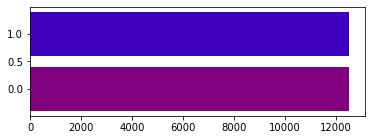

In [4]:
# Print the number of images in each class
clist = [(0, "purple"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
x = np.arange(0, len(["dog","cat"]))
y = image_df['category'].value_counts()
N = y.size

fig, ax = plt.subplots(figsize=(6, 2))
ax.barh(x, y, color=rvb(x/N))

# 3 Plot some Sample Images

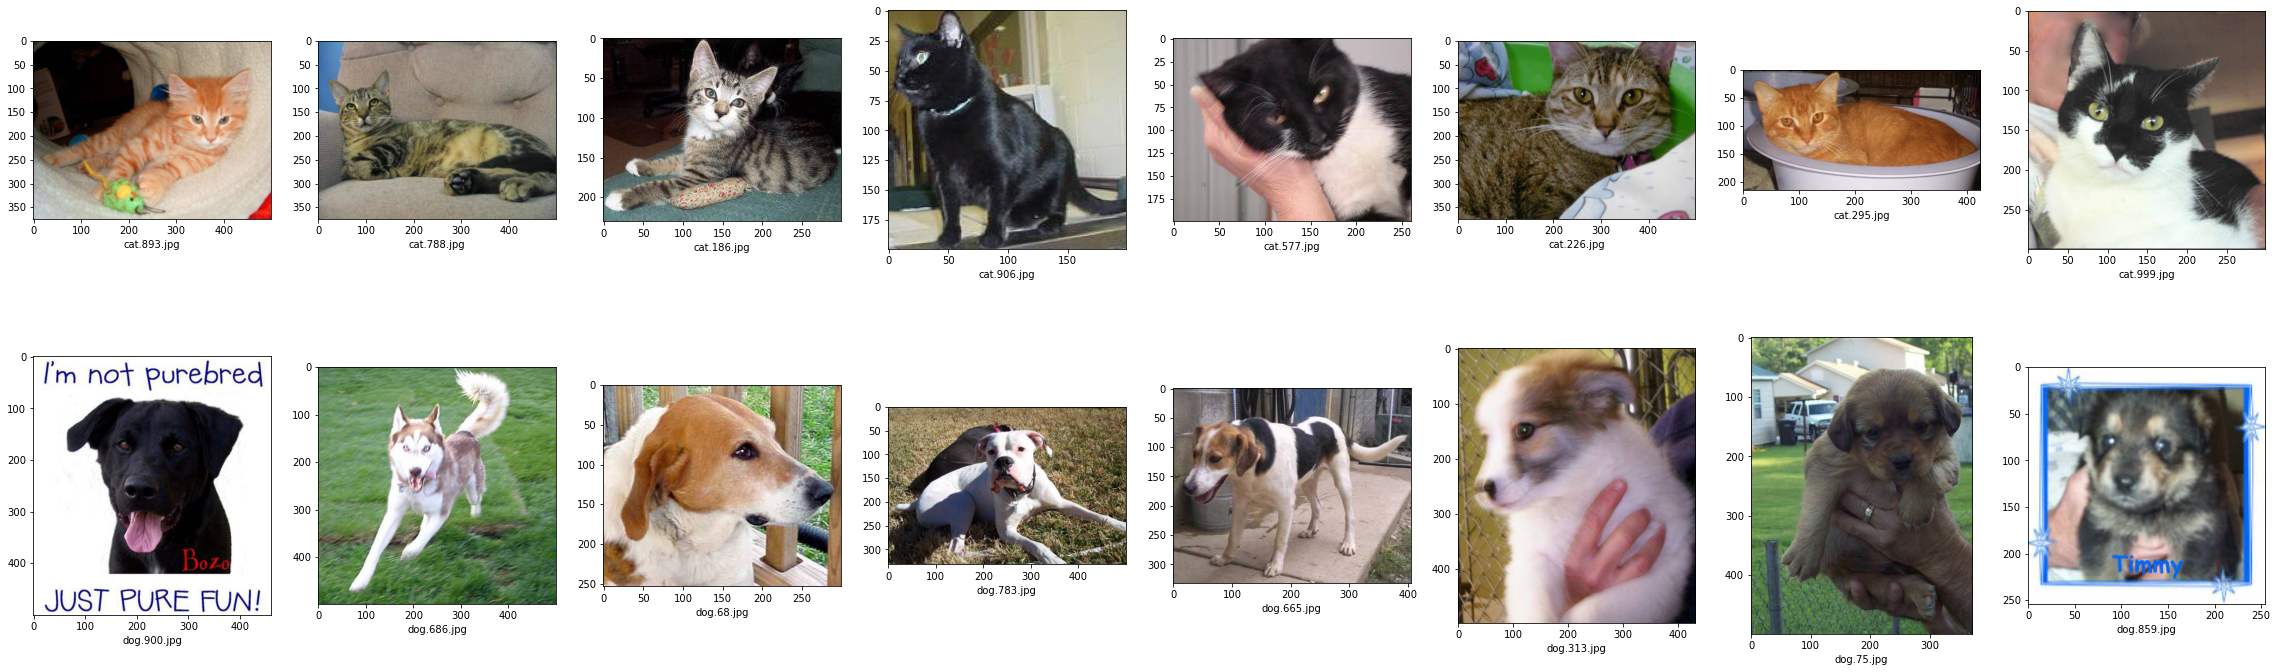

In [5]:
n_pictures = 16 # number of pictures to be shown
columns = int(n_pictures / 2)
rows = 2
plt.figure(figsize=(40, 12))
for i in range(n_pictures):
    num = i + 1
    ax = plt.subplot(rows, columns, i + 1)
    if i < columns:
        image_name = 'cat.' + str(rdn.randint(1, 1000)) + '.jpg'
    else: 
        image_name = 'dog.' + str(rdn.randint(1, 1000)) + '.jpg'
    plt.xlabel(image_name)    
    plt.imshow(load_img(train_path + image_name)) 

#if you get a deprecated warning, you can ignore it

# 4 Split the Data

In [6]:
image_df["category"] = image_df["category"].replace({0:'cat',1:'dog'})

train_df, validate_df = train_test_split(image_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
total_train = train_df.shape[0]

validate_df = validate_df.reset_index(drop=True)
total_validate = validate_df.shape[0]
train_df.head()
print(len(train_df), len(validate_df))

20000 5000


# 5 Preprocess the Images

In [7]:
# set the dimensions to which we will convert the images
img_width, img_height = 128, 128
target_size = (img_width, img_height)
batch_size = 32
rescale=1.0/255

# configure the train data generator
print('Train data:')
train_datagen = ImageDataGenerator(rescale=rescale)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path,
    shuffle=True,
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='binary')

# configure test data generator
# only rescaling
print('Test data:')
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_path,
    shuffle=True,
    x_col='filename', y_col='category',
    classes=['dog', 'cat'],
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='binary')

Train data:
Found 20000 validated image filenames belonging to 2 classes.
Test data:
Found 5000 validated image filenames belonging to 2 classes.


# 6 Define and Compile the Convolutional Neural Network

In [8]:
input_shape = (img_width, img_height, 3)
print(input_shape)

# define  model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(128, (3, 3),  strides=(1, 1),activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# compile model
opt = SGD(lr=0.001, momentum=0.9)
history = model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


(128, 128, 3)


# 7 Train the convolutional neural network

In [ ]:
# train the model
epochs = 30

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

model.save_weights('cats-and-dogs-weights-v1.h5')

Epoch 1/30
625/625 [==============================] - 52s 83ms/step - loss: 0.6782 - accuracy: 0.5673 - val_loss: 0.6681 - val_accuracy: 0.5834
Epoch 2/30
625/625 [==============================] - 45s 72ms/step - loss: 0.6406 - accuracy: 0.6253 - val_loss: 0.6439 - val_accuracy: 0.6358
Epoch 3/30
625/625 [==============================] - 47s 74ms/step - loss: 0.6082 - accuracy: 0.6619 - val_loss: 0.6158 - val_accuracy: 0.6760
Epoch 4/30
351/625 [===============>..............] - ETA: 16s - loss: 0.5744 - accuracy: 0.6985

In [ ]:
# plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# 8 Illustrate Model Performance

In [ ]:
# create a function that brings the pictures into the correct target_size
def prepImage(filepath):
    im = Image.open(filepath).resize(target_size)
    im = np.expand_dims(im, axis=0)
    img = np.array(im)
    return img

# preprare a new dataframe
validate_df_pred = validate_df.copy()
validate_df_pred['pred'] = 0

print(validate_df_pred.head())

plt.figure(figsize=(12, 24))

# create predictions and append them to the dataframe
for index, row in validate_df_pred.iterrows():
    category = row['category']
    img = prepImage(train_path + row['filename'])
    result = model.predict([img])[0][0].astype(int)
    validate_df_pred.at[index, 'pred'] = result.astype('int64')

# create a confusion matrix

y_test = validate_df_pred['category']
y_pred = validate_df_pred['pred'].replace({0:'cat',1:'dog'})

cnf_matrix = confusion_matrix(y_test, y_pred)

%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# 9 Make Predictions on Sample Images

In [ ]:
# make predictions based on the images from the sample folder 
sample_path = "data/cats-and-dogs/sample/"
sample_df = createImageDf(sample_path)
sample_df['pred'] = 0
sample_df.head()

sample_df_pred = sample_df.copy()
plt.figure(figsize=(12, 24))

for index, row in sample_df_pred.iterrows():
    filename = row['filename']
    category = row['category']
    img = prepImage(sample_path + filename)
    result = model.predict([img])[0][0].astype(int)
    sample_df_pred.at[index, 'pred'] = result.astype('int64')

# print random pictures from the sample folder along with their predicted classes
from random import randint
results={0:'cat', 1:'dog'}

plt.figure(figsize=(12, 24))

for i in range (0, 3):
    randomindex = randint(0, sample_df_pred.shape[0] - 1) 
    filepath = sample_path + sample_df_pred.at[randomindex ,'filename']
    prediction = sample_df_pred.at[randomindex ,'pred']
    img = Image.open(filepath).resize(target_size)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' + '\n' + ' predicted: '  + str(results[prediction]))
plt.tight_layout()
plt.show()